# Running Comcam Closed Loop with Pan-Starrs catalog (Low Density Field Example)

## Create sky catalog for `ts_phosim` closed loop

To perform a closed loop run with `ts_phosim` we need a sky catalog as a text file. 
To generate the text file for a closed loop from a reference catalog you can use `createSkyFile.py` which is a command line function available once running `scons` on `ts_phosim`.
Here is an example of how it was used to generate the sky catalog file for the closed loop test further down in this notebook.

In [1]:
! createSkyFile.py --help

usage: createSkyFile.py [-h] [--radius RADIUS] [--magMax MAGMAX]
                        [--magMin MAGMIN]
                        butlerPath collectionName refCatName ra dec filter
                        outFile

positional arguments:
  butlerPath       Butler Repository with refcats.
  collectionName   Collection with refcats within butler repo.
  refCatName       Reference Catalog Dataset Name.
  ra               RA of pointing in degrees.
  dec              Dec of pointing in degrees.
  filter           Filter name for magnitudes from source catalog.
  outFile          Output filepath for final catalog.

optional arguments:
  -h, --help       show this help message and exit
  --radius RADIUS  Radius of catalog footprint in degrees. (default: 1.8)
  --magMax MAGMAX  Maximum magnitude of sources in catalog. (default: 99.0)
  --magMin MAGMIN  Minimum magnitude of sources in catalog. (default: -99.0)


In [2]:
# Arguments for createSkyFile used in the closed loop example below and available for others to use
butlerPath = '/repo/main' 
collectionName = 'refcats/DM-28636'
catalogName = 'ps1_pv3_3pi_20170110' # To use Gaia replace with: 'gaia_dr2_20200414'
pointingRA = 197.46
pointingDec = 24.33
bandName = 'g' # To use Gaia replace with: 'phot_g_mean'
outputName = 'ps1_high.txt'
radius = 1.0

In [3]:
! createSkyFile.py $butlerPath $collectionName $catalogName $pointingRA $pointingDec $bandName $outputName --radius $radius

In [4]:
! head ps1_high.txt

# Id	Ra	Decl	Mag
0	196.54297824087698	24.04864005283946	23.098052672889455
1	196.5435165632371	24.049945849151424	22.239037689051816
2	196.54572443739102	24.041904352370945	22.266544037834723
3	196.54619676605665	24.047642154178195	22.340522980910013
4	196.54704103443987	24.043797321504528	22.343748783789575
5	196.54806163246866	24.097306859698413	23.065239174477195
6	196.5480850047616	24.059833130854695	22.741266431317552
7	196.54988448664156	24.069574199344686	23.881834727032192
8	196.5510834643081	24.116612136828046	23.288513449713214


## Running closed loop

The closed loop now runs the donut selection using the `generateDonutCatalogWcsTask` in `ts_wep`.

Here is the configuration we use in the closed loop. 

```
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogOnlineTaskConfig.
    config:
      filterName: 'g'
      referenceSelector.doMagLimit: True
      referenceSelector.magLimit.maximum: 15.90
      referenceSelector.magLimit.minimum: 8.74
      referenceSelector.magLimit.fluxField: 'g_flux'
      doDonutSelection: True
      donutSelector.fluxField: 'g_flux'
```

`referenceSelector.doMagLimit`: This turns on a magnitude limiter in the reference catalog task that provides magnitude bounds on the sources we will grab for our donuts. The magnitude limits are set by the `referenceSelector.magLimit.maximum` and `referenceSelector.magLimit.minimum` commands following. The magnitudes here in the closed loop come from the file `ts_wep/policy/task/magLimitStar.yaml`. In the future we will provide code to generate default pipeline configuration files for a given bandpass automatically. For more information on all the configuration settings available here see the class [`ReferenceSourceSelectorConfig`](https://github.com/lsst/meas_algorithms/blob/main/python/lsst/meas/algorithms/sourceSelector.py) in the `meas_algorithms` package.

`doDonutSelection`: This activates the donut selection task. The default settings in this task choose only isolated donuts defined as those donuts that are at least 2 magnitudes brighter than any donuts that overlap with them where the overlap radius is set to 126 pixels. These default settings can be overridden in this configuration file if desired. For more information on all the configuration settings available see the class [`DonutSourceSelectorTaskConfig`](https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/DonutSourceSelectorTask.py) in the `ts_wep` package.

In [5]:
! imgCloseLoop.py --help

usage: imgCloseLoop.py [-h] [--inst INST] [--filterType FILTERTYPE]
                       [--rotCam ROTCAM] [--m1m3FErr M1M3FERR]
                       [--numOfProc NUMOFPROC] [--iterNum ITERNUM]
                       [--output OUTPUT] [--log-level LOG_LEVEL] [--clobber]
                       [--boresightDeg BORESIGHTDEG BORESIGHTDEG]
                       [--skyFile SKYFILE] [--eimage]

Run AOS closed-loop simulation (default is amplifier files).

optional arguments:
  -h, --help            show this help message and exit
  --inst INST           Instrument to use: comcam or lsstfam. (default:
                        comcam)
  --filterType FILTERTYPE
                        Filter type to use: U, G, R, I, Z, Y or empty string
                        for reference wavelength. (default: '')
  --rotCam ROTCAM       Rotate camera (degree) in counter-clockwise direction.
                        (default: 0.0)
  --m1m3FErr M1M3FERR   Ratio of M1M3 actuator force error between 0 and 1.
 

The command used to run the closed loop with the new sky catalog file:

`imgCloseLoop.py --inst comcam --numOfProc 9 --output /project/aos/closed_loop_tests/comcam_102621 --skyFile ps1_high.txt --log-level 1 --boresightDeg 197.46 24.33 --clobber`

## Closed Loop Output

Now let's look at the output of the closed loop iterations.

In [6]:
closedLoopDirectory = '/project/aos/closed_loop_tests/comcam_110421/'

### Check FWHM

First, we look at the plot generated at completion of the closed loop that shows the progression of the FWHM parameter. In this case we see that the loop did converge during the 5 iterations.

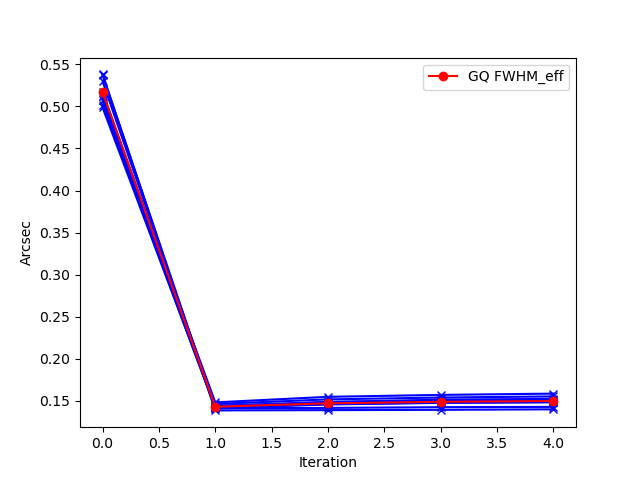

In [7]:
import os
from IPython.display import Image
Image(os.path.join(closedLoopDirectory, 'fwhmIters.png'))

### Check source selection

Next, let's open the images and check which donuts were chosen for the catalog.

In [8]:
butlerDir = os.path.join(closedLoopDirectory, 'phosimData')

In [9]:
from lsst.daf.butler import Butler

In [10]:
butler = Butler(butlerDir)
registry = butler.registry

Inside the butler repository for the closed loop there are collections for each of the iterations listed as `ts_phosim_xxx`:

In [11]:
list(registry.queryCollections())

['LSSTCam/raw/all',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'refcats/gen2',
 'refcats',
 'LSSTCam/defaults',
 'skymaps',
 'LSSTComCam/raw/all',
 'LSSTComCam/calib',
 'LSSTComCam/calib/unbounded',
 'ts_phosim_9006001',
 'ts_phosim_9006011',
 'ts_phosim_9006021',
 'ts_phosim_9006031',
 'ts_phosim_9006041']

Inside the first iteration we can grab the `postISR` image for the extra-focal image and the `donutCatalog`.

In [12]:
list(registry.queryDataIds('exposure'))

[{instrument: 'LSSTComCam', exposure: 4021123106002, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106001, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106012, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106011, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106022, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106021, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106032, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106031, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106042, ...},
 {instrument: 'LSSTComCam', exposure: 4021123106041, ...}]

Grab one of the detectors. Comcam detectors are numbered 0-8. Detector 4 is the middle of the raft.

In [13]:
detectorNum = 4

In [14]:
postIsrExpExtra = butler.get('postISRCCD', dataId={'detector': detectorNum, 'instrument': 'LSSTComCam', 'exposure': 4021123106001}, collections='ts_phosim_9006001')
# Note we specify a visit instead of an exposure for the donutCatalog
donutCatalog = butler.get('donutCatalog', dataId={'detector': detectorNum, 'instrument': 'LSSTComCam', 'visit': 4021123106001}, collections='ts_phosim_9006001')

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'PostISR image of detector R22_S11')

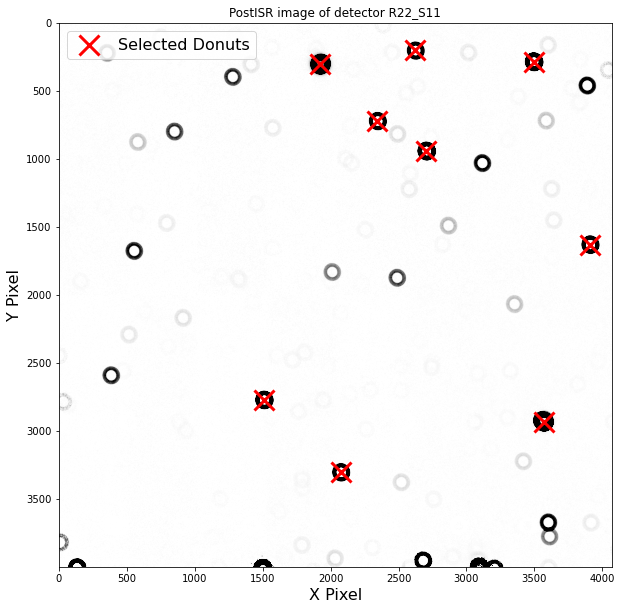

In [16]:
fig = plt.figure(figsize=(10,10))
plt.imshow(postIsrExpExtra.getImage().getArray(), vmax=100, vmin=0, cmap=plt.get_cmap('Greys'))
plt.scatter(donutCatalog['centroid_x'], donutCatalog['centroid_y'], c='r', marker='x', s=400, lw=3, label='Selected Donuts')
plt.legend(fontsize=16)
plt.xlabel('X Pixel', size=16)
plt.ylabel('Y Pixel', size=16)
plt.title(f'PostISR image of detector {postIsrExpExtra.getDetector().getName()}')

We see some of the donuts were not detected even though it looks like there are no donuts around. To see the full source catalog we load our catalog we created at the beginning of the notebook and plot all sources on the detector.

In [17]:
import numpy as np
fullCatalog = np.genfromtxt('ps1_high.txt', names=['id', 'ra', 'dec', 'mag'])

In [18]:
wcs = postIsrExpExtra.getWcs()

In [19]:
fullSrcCatX, fullSrcCatY = wcs.skyToPixelArray(fullCatalog['ra'], fullCatalog['dec'], degrees=True)

Text(0.5, 1.0, 'PostISR image of detector R22_S11')

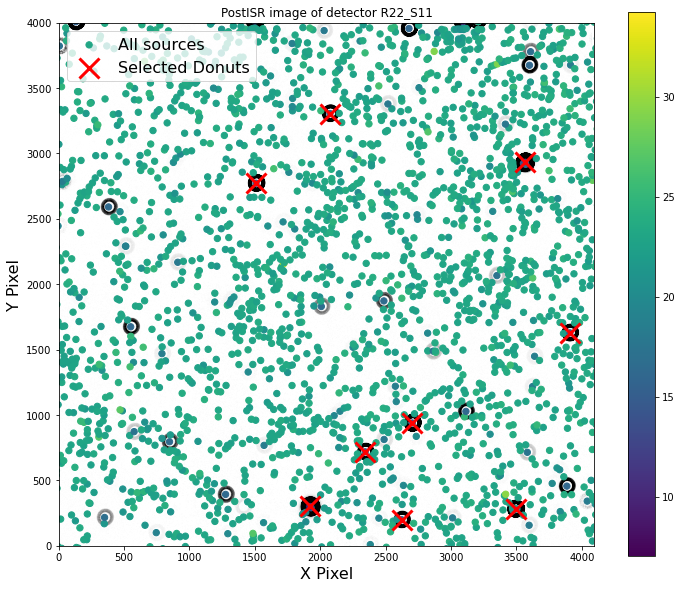

In [20]:
fig = plt.figure(figsize=(12,10))
plt.imshow(postIsrExpExtra.getImage().getArray(), vmax=100, vmin=0, cmap=plt.get_cmap('Greys'))
plt.scatter(fullSrcCatX, fullSrcCatY, c=fullCatalog['mag'], s=40, label='All sources')
plt.colorbar()
plt.scatter(donutCatalog['centroid_x'], donutCatalog['centroid_y'], c='r', marker='x', s=400, lw=3, label='Selected Donuts')
plt.xlim((0, 4096))
plt.ylim((0, 4000))
plt.legend(fontsize=16)
plt.xlabel('X Pixel', size=16)
plt.ylabel('Y Pixel', size=16)
plt.title(f'PostISR image of detector {postIsrExpExtra.getDetector().getName()}')

Now we can see that many source that previously looked isolated are in fact not isolated sources.

### Compare OPD Zernikes to WEP Zernikes

In [21]:
detectorNum = 4

In [22]:
zernikeEstAvg = butler.get('zernikeEstimateAvg', dataId={'detector': detectorNum, 'instrument': 'LSSTComCam', 'visit': 4021123106001}, collections='ts_phosim_9006001')
zernikeEstRaw = butler.get('zernikeEstimateRaw', dataId={'detector': detectorNum, 'instrument': 'LSSTComCam', 'visit': 4021123106001}, collections='ts_phosim_9006001')

In [23]:
opdZernikes = np.genfromtxt(os.path.join(closedLoopDirectory, 'iter0', 'img', 'opd.zer'))

Text(0.5, 1.0, 'Comparison of ts_wep estimated Zernikes versus OPD Truth for detector R22_S11')

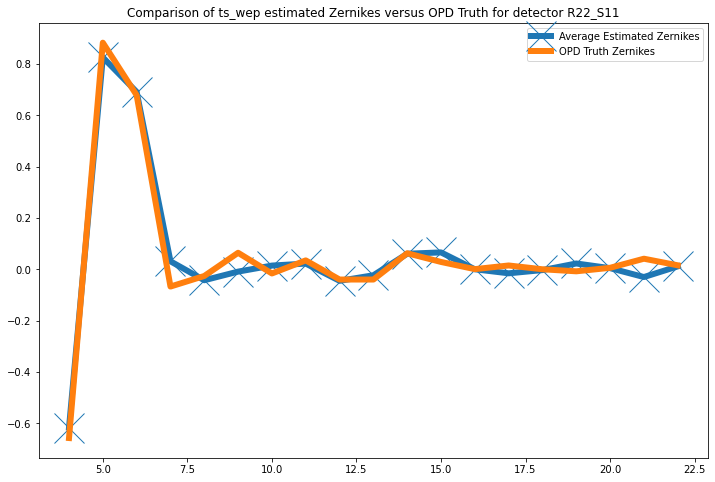

In [24]:
fig = plt.figure(figsize=(12, 8))
zernikeNums = np.arange(4, 23)
plt.plot(zernikeNums, zernikeEstAvg, '-x', label='Average Estimated Zernikes', lw=6, markersize=30)
plt.plot(zernikeNums, opdZernikes[4], label='OPD Truth Zernikes', lw=6)
plt.legend()
plt.title(f'Comparison of ts_wep estimated Zernikes versus OPD Truth for detector {postIsrExpExtra.getDetector().getName()}')

Text(0.5, 1.0, 'Comparison of ts_wep estimated Zernikes versus OPD Truth for detector R22_S11')

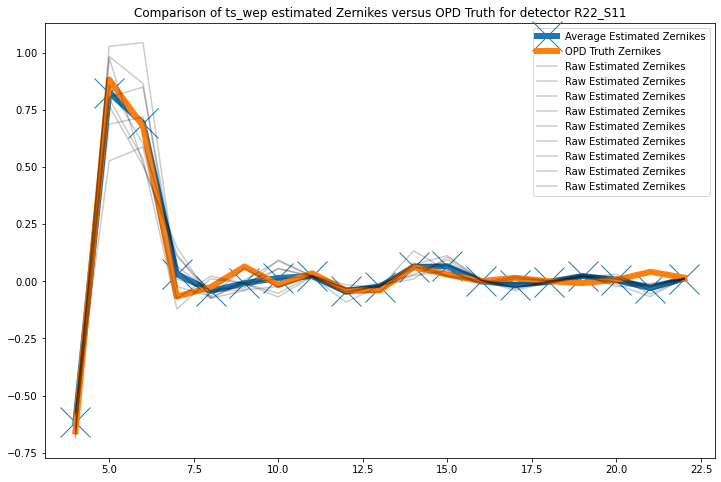

In [25]:
fig = plt.figure(figsize=(12, 8))
zernikeNums = np.arange(4, 23)
plt.plot(zernikeNums, zernikeEstAvg, '-x', label='Average Estimated Zernikes', lw=6, markersize=30)
plt.plot(zernikeNums, opdZernikes[4], label='OPD Truth Zernikes', lw=6)
for i in range(len(zernikeEstRaw)):
    plt.plot(zernikeNums, zernikeEstRaw[i], c='k', alpha=0.2, label='Raw Estimated Zernikes')
plt.legend()
plt.title(f'Comparison of ts_wep estimated Zernikes versus OPD Truth for detector {postIsrExpExtra.getDetector().getName()}')

### Analyze donut stamps

The donut stamps are also saved within the repository and can be retrieved using the butler.

In [26]:
donutStampsExtra = butler.get('donutStampsExtra', dataId={'detector': detectorNum, 'instrument': 'LSSTComCam', 'visit': 4021123106001}, collections='ts_phosim_9006001')

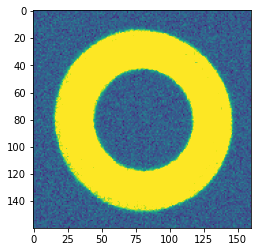

In [27]:
plt.imshow(donutStampsExtra[-1].stamp_im.getImage().getArray(), vmax=100)

In [28]:
donutStampsExtra[0]

DonutStamp(stamp_im=lsst.afw.image.maskedImage.MaskedImageF=(image=[[ 12.782146     5.7136464   18.436947   ...  12.782146    14.195847
    4.299947  ]
 [  9.954746    19.850647    14.195847   ...  -4.1822534    8.541046
   -1.3548534 ]
 [ -2.7685533   21.264347    -2.7685533  ... -25.387753     0.05884664
   -1.3548534 ]
 ...
 [  7.1273465  -22.560352    -7.009653   ...   4.299947    -8.423353
  -12.6644535 ]
 [-15.491853     1.4725466    9.954746   ...  -5.5959535  -22.560352
    5.7136464 ]
 [ -1.3548534    7.1273465   -9.837053   ...  -8.423353     0.05884664
    8.541046  ]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}
variance=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ..

## Run task on its own

In [29]:
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig

/home/brycek/notebooks/Commissioning/aos/ts_wep/python/lsst/ts/wep/task/DonutSourceSelectorTask.py:122: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def selectSources(self, sourceCat, bbox):


First set up the configuration settings to match our original task in the closed loop.

In [30]:
donutCatConfig = GenerateDonutCatalogWcsTaskConfig()

In [31]:
donutCatConfig.filterName = 'g'
donutCatConfig.referenceSelector.doMagLimit = True
donutCatConfig.doDonutSelection = True
donutCatConfig.donutSelector.fluxField = 'g_flux'

Set the magnitude limit parameter from the object defined in `lsst.meas.algorithms`.

In [32]:
from lsst.meas.algorithms import MagnitudeLimit

In [33]:
donutCatConfig.referenceSelector.magLimit=MagnitudeLimit(maximum=15.90, minimum=8.74, fluxField='g_flux')

Now we can view our final configuration settings.

In [34]:
donutCatConfig

lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTaskConfig(saveMetadata=True, saveLogOutput=True, filterName='g', referenceSelector={'doMagLimit': True, 'doFlags': False, 'doUnresolved': False, 'doSignalToNoise': False, 'doMagError': False, 'magLimit': {'minimum': 8.74, 'maximum': 15.9, 'fluxField': 'g_flux'}, 'flags': {'good': [], 'bad': []}, 'unresolved': {'minimum': None, 'maximum': 0.5, 'name': 'base_ClassificationExtendedness_value'}, 'signalToNoise': {'minimum': None, 'maximum': None, 'fluxField': 'flux', 'errField': 'flux_err'}, 'magError': {'minimum': None, 'maximum': None, 'magErrField': 'mag_err'}, 'colorLimits': {}}, donutSelector={'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'fluxField': 'g_flux', 'donutRadius': 63.0, 'isoMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, doDonutSelection=True, connections={'refCatalogs': 'cal_ref_cat', 'exposure': 'postISRCCD', 'donutCatalog': 'donutCatalog'})

In [35]:
donutCat = GenerateDonutCatalogWcsTask(config=donutCatConfig)

### Configure reference catalog input

Here we use the pointing information to only load the pieces of the reference catalog that cover the area of the sky in our field of view.

In [36]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
# Initialize with pointing information
boresightRotAng = 0.0
refCatInterface = RefCatalogInterface(pointingRA, pointingDec, boresightRotAng)

#### Get `shardIds` for pointing

In [37]:
%%time
htmIds = refCatInterface.getHtmIds()

CPU times: user 348 µs, sys: 61 µs, total: 409 µs
Wall time: 421 µs


In [38]:
htmIds

array([223876, 223889, 223890, 223891, 223896, 223897, 223898, 223899,
       223900, 223901, 223902, 223903, 223928, 223929, 223931, 224328,
       224353, 224356, 224358, 224359, 224366, 224372, 223877, 223878,
       223879, 223888, 223893, 223894, 223895, 223922, 223930, 223932,
       223933, 223935, 223952, 223954, 223955, 223961, 223965, 224329,
       224330, 224331, 224352, 224354, 224355, 224357, 224364, 224365,
       224367, 224373, 224374, 224375, 224382])

#### Get butler data references for the pieces of the reference catalogs we want

In [40]:
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
butler = Butler('/project/aos/closed_loop_tests/comcam_110421/phosimData/')
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, 'cal_ref_cat', 'refcats/gen2')

### Run the task
We provide the dataRefs to the shards of the reference catalog we need and an `lsst.afw.exposure` (here we use the same postISR exposure from above).

In [41]:
donutCatTaskExtra = donutCat.run(dataRefs, postIsrExpExtra).donutCatalog

The final catalog is saved as a pandas dataframe.

In [42]:
donutCatTaskExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux
0,3.444518,0.424525,1920.118363,300.525887,3.348111e+08
1,3.447319,0.426124,3568.182810,2932.417191,8.806964e+07
2,3.444497,0.426051,3494.179217,281.641755,8.266130e+06
3,3.445197,0.425285,2703.486352,939.022758,6.869590e+06
4,3.447148,0.424127,1508.563928,2772.455904,4.093969e+06
5,3.445931,0.426454,3908.808358,1628.197747,2.977304e+06
6,3.447716,0.424675,2074.205696,3305.280228,2.390421e+06
7,3.444963,0.424936,2343.496133,718.599022,2.213806e+06
8,3.444410,0.425206,2622.539720,199.256143,1.935509e+06


And we can plot on top of the image to see that it matches the catalog from the closed loop.

Text(0.5, 1.0, 'PostISR image of detector R22_S11')

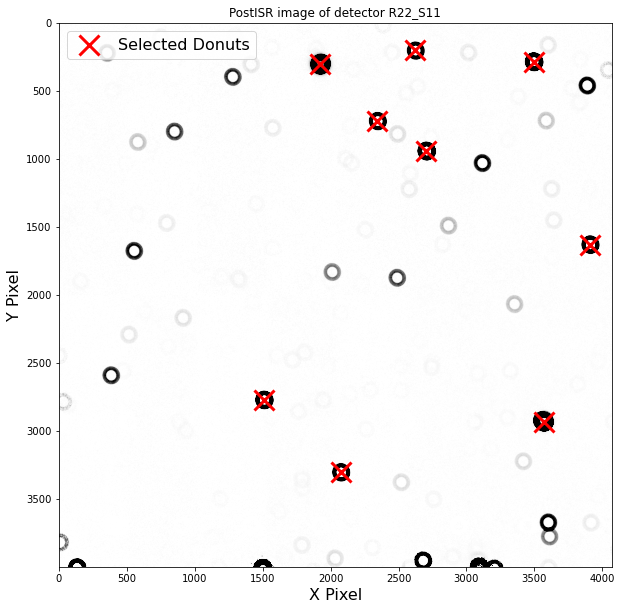

In [43]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(postIsrExpExtra.getImage().getArray(), vmax=40, vmin=0)
plt.imshow(postIsrExpExtra.getImage().getArray(), vmax=100, vmin=0, cmap=plt.get_cmap('Greys'))
plt.scatter(donutCatTaskExtra['centroid_x'], donutCatTaskExtra['centroid_y'], c='r', marker='x', s=400, lw=3, label='Selected Donuts')
plt.legend(fontsize=16)
plt.xlabel('X Pixel', size=16)
plt.ylabel('Y Pixel', size=16)
plt.title(f'PostISR image of detector {postIsrExpExtra.getDetector().getName()}')